# Setting up ML pipeline for fire index equation discovery

Author: Jatan Buch (v1, 231210)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from scipy import stats, interpolate
from scipy.optimize import minimize
from scipy.special import gamma
from sklearn.linear_model import LinearRegression
from math import factorial
import itertools
import re # for regular expressions

import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray
import zarr
import xesmf as xe # for regridding
import pickle # for saving and loading models
from pathlib import Path

# CDS API
import cdsapi

# To map GRIB files to NetCDF Common Data Model
import cfgrib

# self-libraries
from data_utils import *

from shapely.geometry import Point, mapping, LineString
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader
from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from calendar import monthrange
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from plot_params_mpl39 import params
import matplotlib.pylab as pylab
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns
#pylab.rcParams.update(params)
#cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

## Creating indices for fire xarray

In [3]:
shrub_fire_clim_df= init_fire_clim_df('shrubland')
forest_fire_clim_df= init_fire_clim_df('forest')
grassland_fire_clim_df= init_fire_clim_df('grassland')

100%|██████████| 15824/15824 [03:44<00:00, 70.42it/s]


In [6]:
shrub_fire_clim_df.to_hdf('../sav_files/shrubland_fire_clim_df.h5', key='df', mode='w')
forest_fire_clim_df.to_hdf('../sav_files/forest_fire_clim_df.h5', key='df', mode='w')
grassland_fire_clim_df.to_hdf('../sav_files/grassland_fire_clim_df.h5', key='df', mode='w')

## Data summary plots

In [9]:
forest_fire_clim_df= pd.read_hdf('../sav_files/forest_fire_clim_df.h5')
grassland_fire_clim_df= pd.read_hdf('../sav_files/grassland_fire_clim_df.h5')

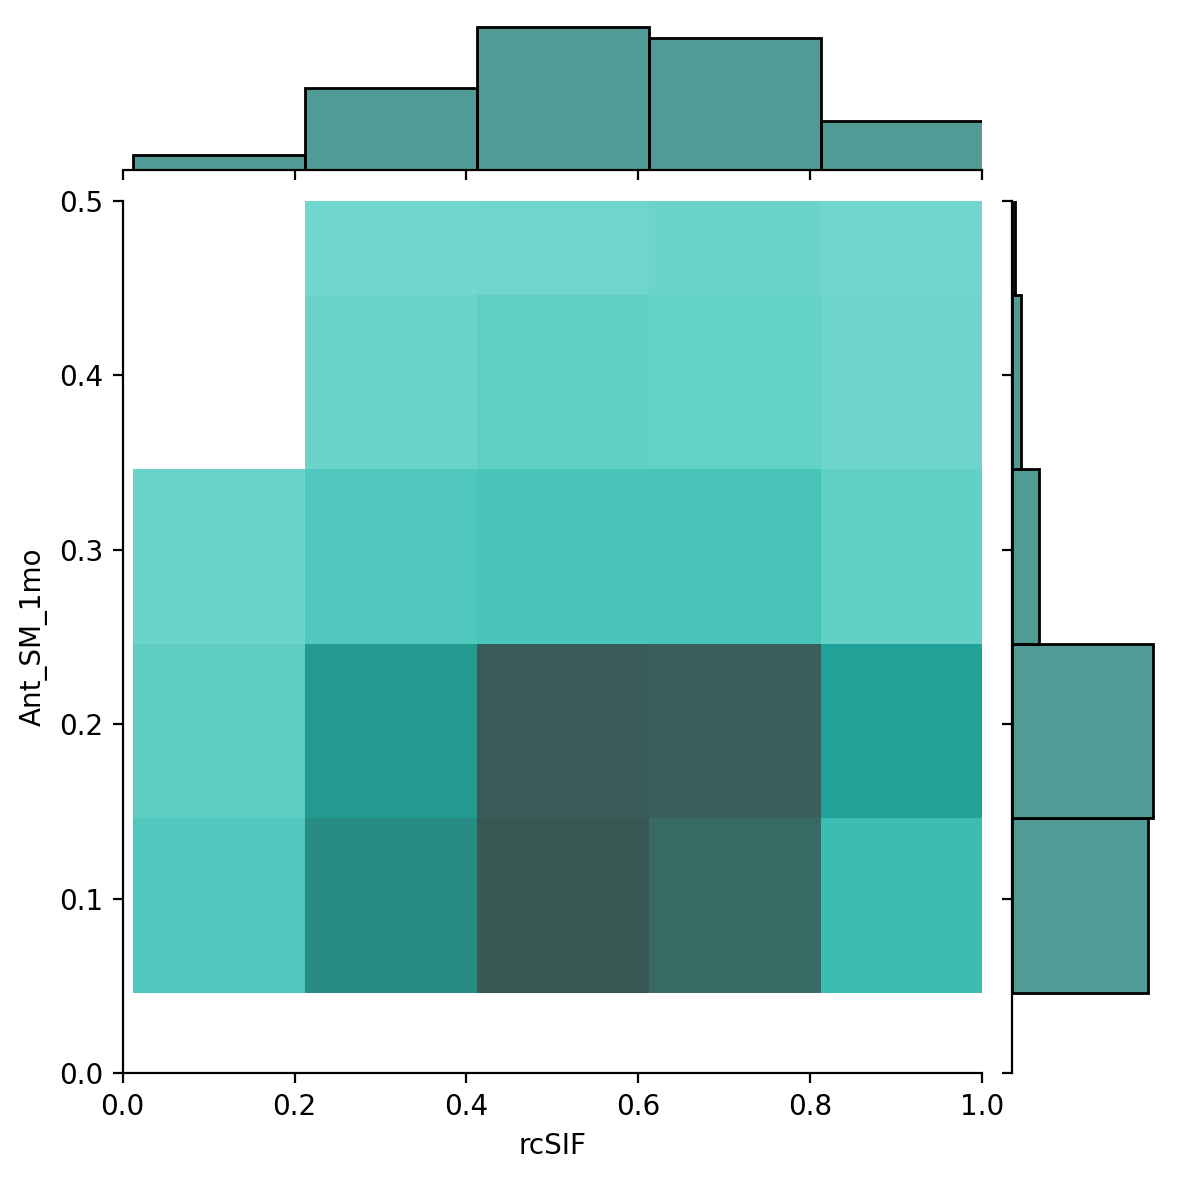

In [7]:
sns_forest_rcsif_sm_plot= sns.jointplot(data=forest_fire_clim_df[(forest_fire_clim_df.SM > 0)&(forest_fire_clim_df.rcSIF > 0)], x="rcSIF", y="Ant_SM_1mo", xlim= (0, 1), ylim= (0, 0.5), \
                                                                kind= 'hist', color= sns.color_palette(palette='BrBG')[5], binwidth=(0.2, 0.1), \
                                                                marginal_kws=dict(bins= 8, rug=True)) #binwidth=(0.1, 0.1)
sns_forest_rcsif_sm_plot.savefig('../plots/forest_rcsif_ant_sm_1mo_plot_fires.pdf')

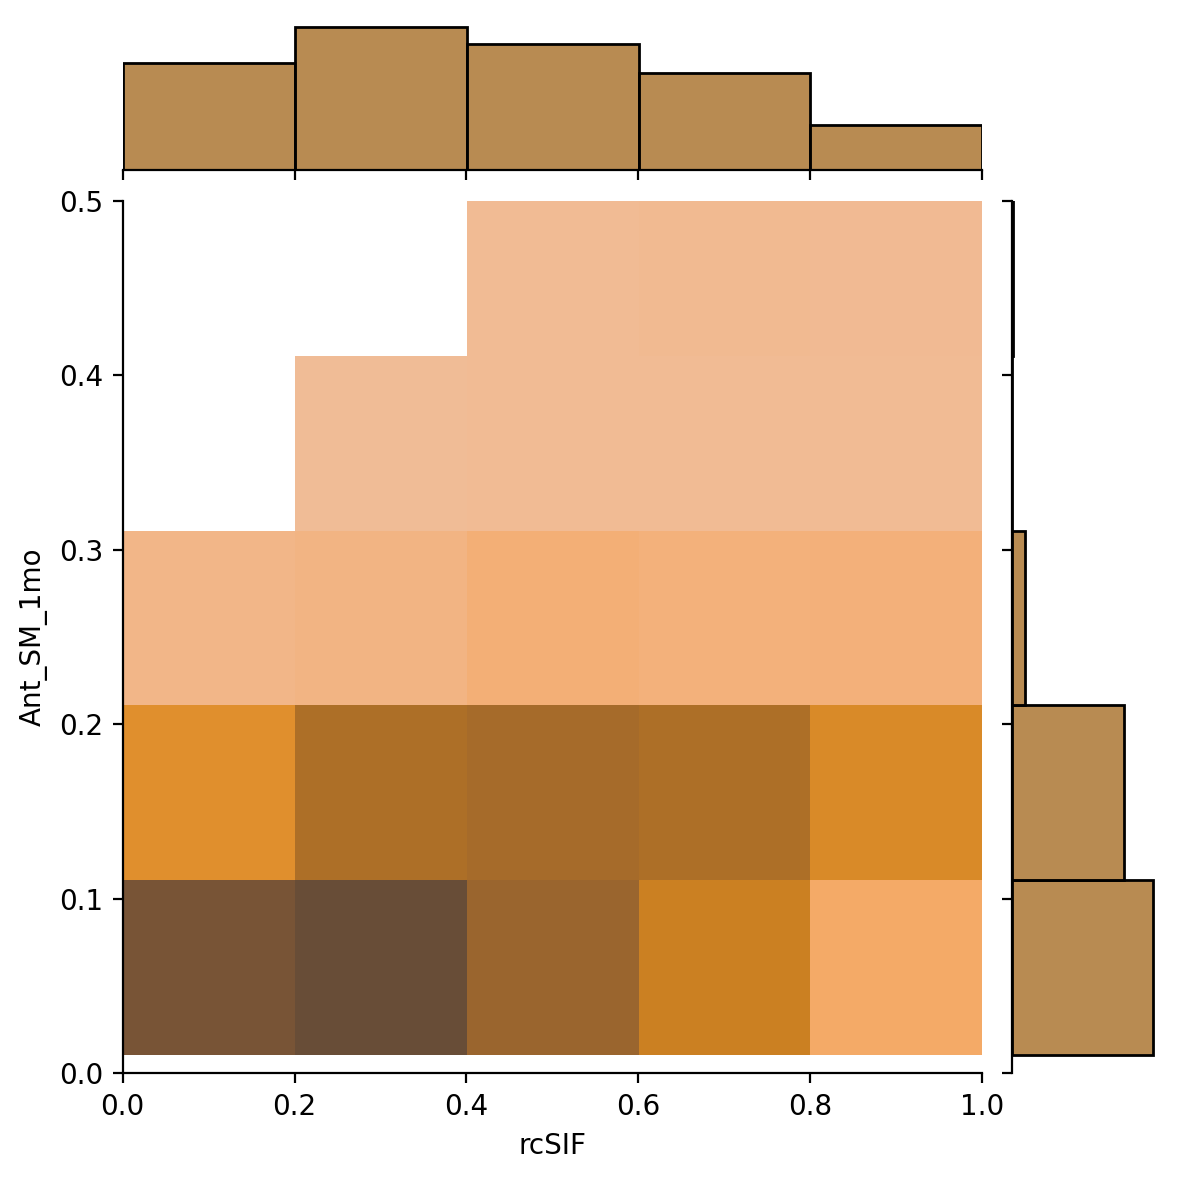

In [17]:
sns_grassland_rcsif_sm_plot= sns.jointplot(data= grassland_fire_clim_df[(grassland_fire_clim_df.SM > 0)&(grassland_fire_clim_df.rcSIF > 0)], x="rcSIF", y="Ant_SM_1mo", xlim= (0, 1), ylim= (0, 0.5), \
                                                                kind= 'hist', color= sns.color_palette(palette='BrBG')[0], binwidth=(0.2, 0.1), \
                                                                marginal_kws=dict(bins= 8, rug=True)) #
sns_grassland_rcsif_sm_plot.savefig('../plots/grassland_rcsif_ant_sm_1mo_plot_fires.pdf')

In [69]:
sns.color_palette(palette='BrBG')

[(0.6313725490196078, 0.3951557093425605, 0.09573241061130335),
 (0.8572856593617839, 0.7257977700884274, 0.4471357170319107),
 (0.9636293733179546, 0.9237985390234525, 0.8185313341022683),
 (0.8299115724721262, 0.9294886582083814, 0.9152633602460593),
 (0.4615916955017304, 0.7748558246828146, 0.7299500192233758),
 (0.0878892733564014, 0.479123414071511, 0.44775086505190315)]

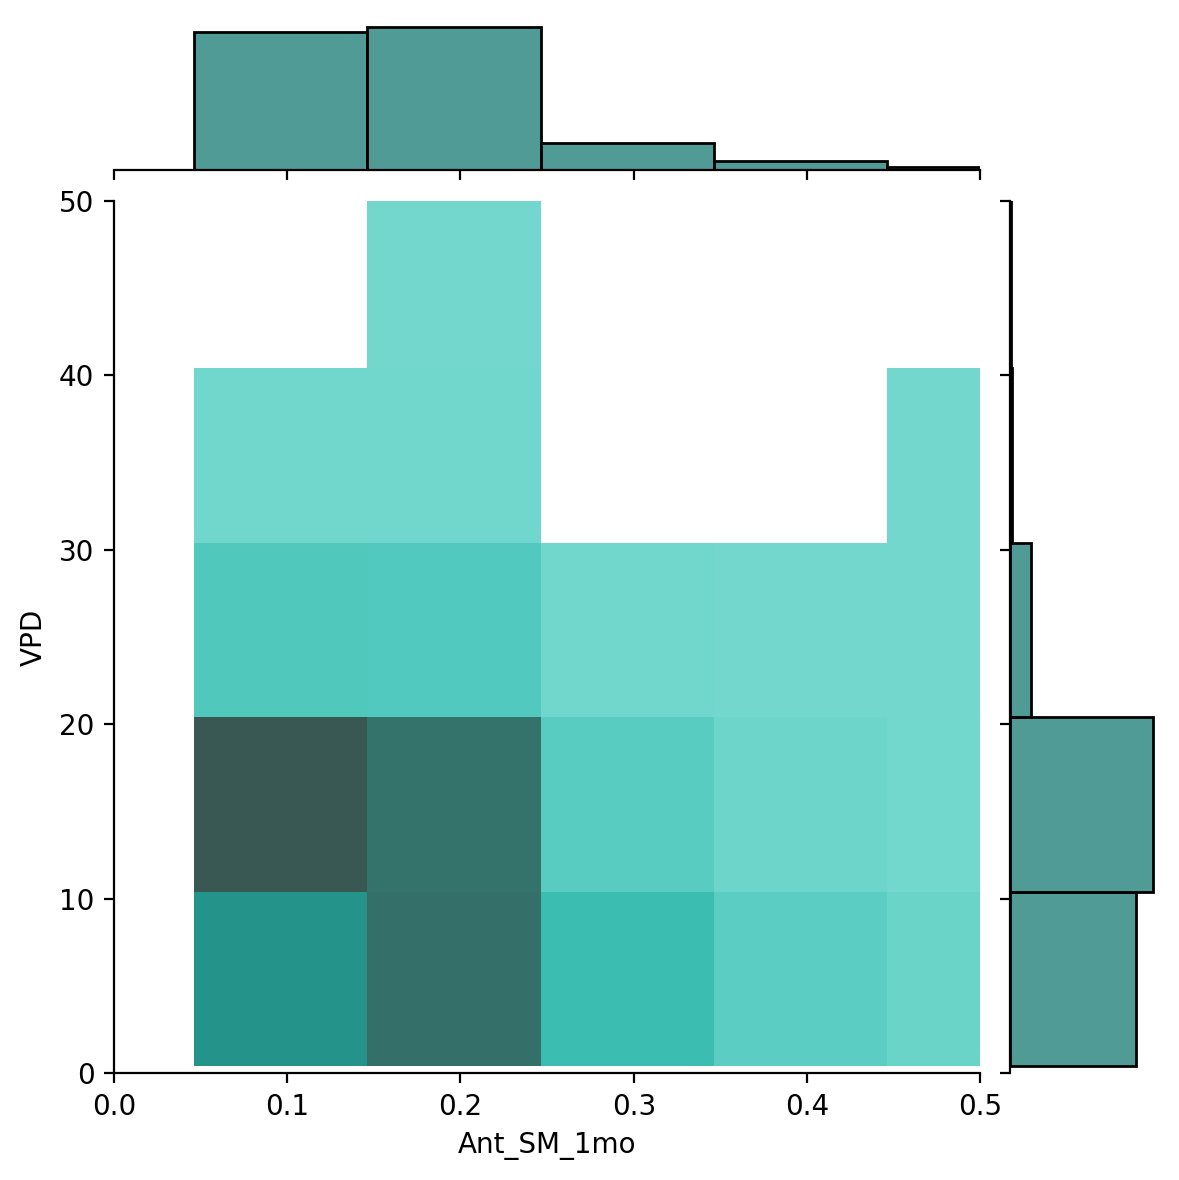

In [78]:
sns_forest_sm_plot= sns.jointplot(data=forest_fire_clim_df[forest_fire_clim_df.SM > 0], x="Ant_SM_1mo", y="VPD", xlim= (0, 0.5), ylim= (0, 50), \
                                                                kind= 'hist', color= sns.color_palette(palette='BrBG')[5], binwidth=(0.1, 10), \
                                                                marginal_kws=dict(bins=5, rug=True)) 
sns_forest_sm_plot.savefig('../plots/forest_vpd_ant_sm_1mo_plot_fires.pdf')

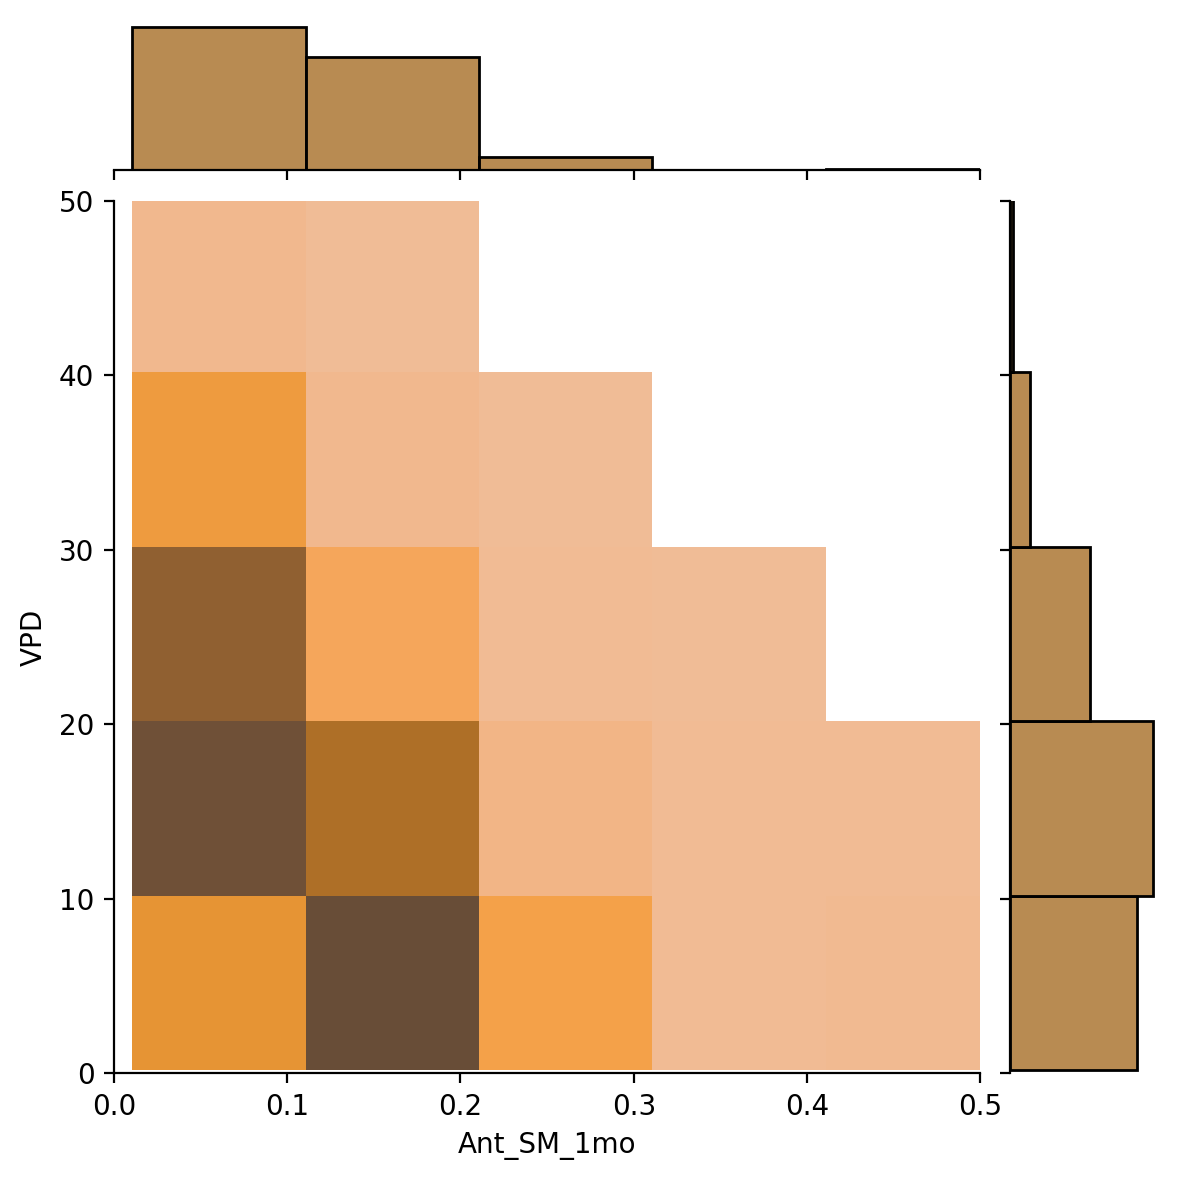

In [79]:
sns_grassland_sm_plot= sns.jointplot(data= grassland_fire_clim_df[grassland_fire_clim_df.SM > 0], x="Ant_SM_1mo", y="VPD", xlim= (0, 0.5), ylim= (0, 50), \
                                                                kind= 'hist', color= sns.color_palette(palette='BrBG')[0], binwidth=(0.1, 10), \
                                                                marginal_kws=dict(bins= 5, rug=True)) #binwidth=(0.1, 10)
sns_grassland_sm_plot.savefig('../plots/grassland_vpd_ant_sm_1mo_plot_fires.pdf')

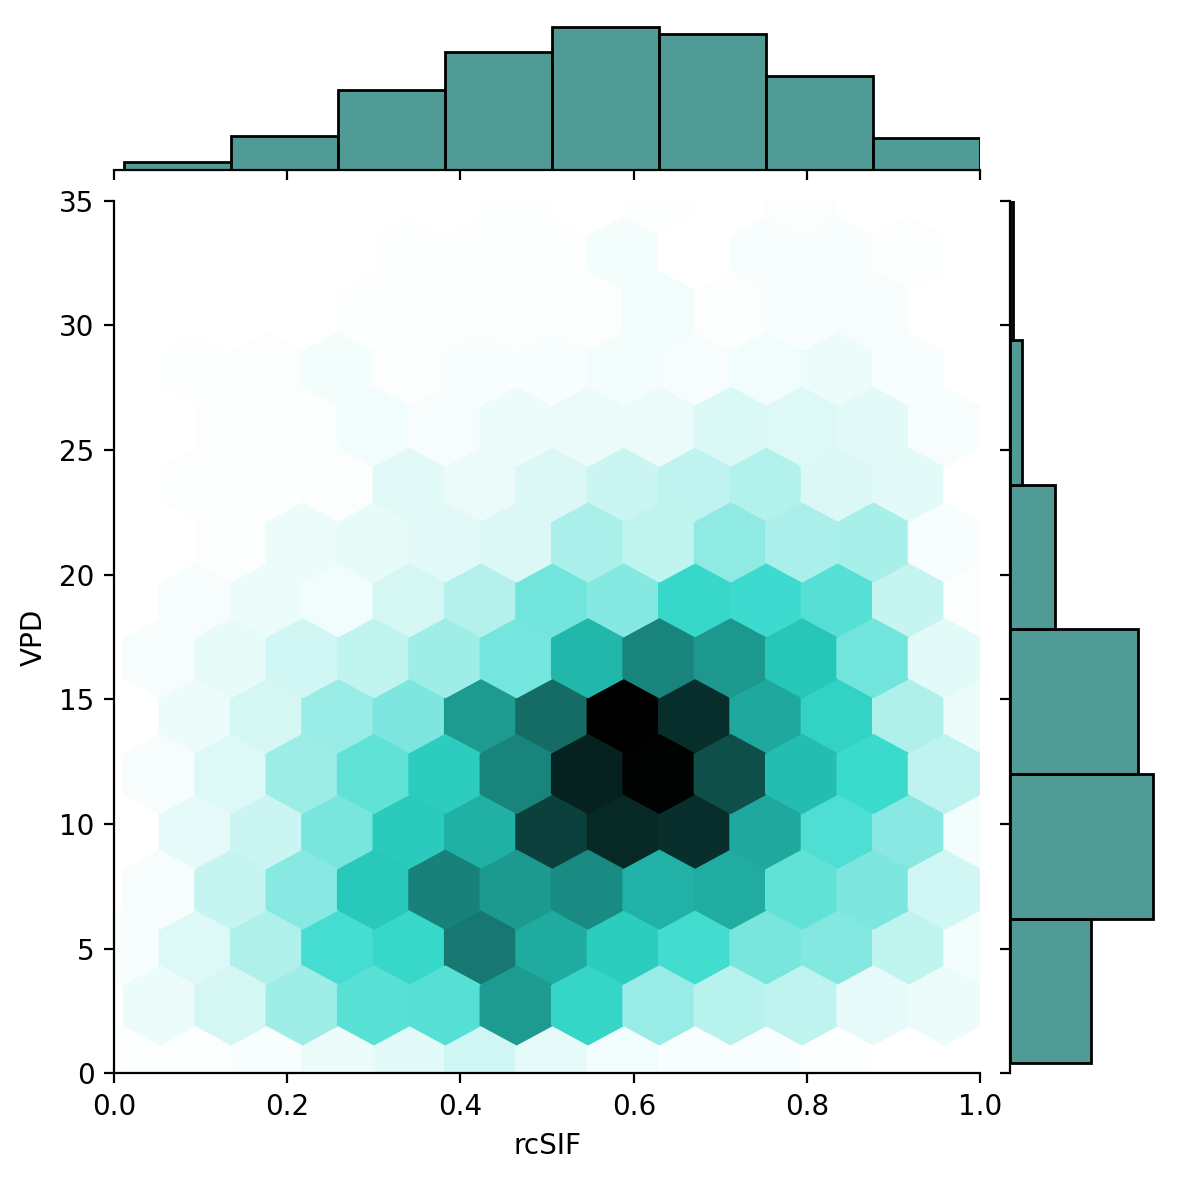

In [76]:
sns_forest_rcsif_plot= sns.jointplot(data=forest_fire_clim_df[forest_fire_clim_df.rcSIF > 0], x="rcSIF", y="VPD", xlim= (0, 1), ylim= (0, 35), \
                                                                kind= 'hex', color= sns.color_palette(palette='BrBG')[5], gridsize= (12, 10),\
                                                                marginal_kws=dict(bins=8, rug=True)) # binwidth=(0.2, 10),
sns_forest_rcsif_plot.savefig('../plots/forest_vpd_rcsif_plot_fires.pdf')

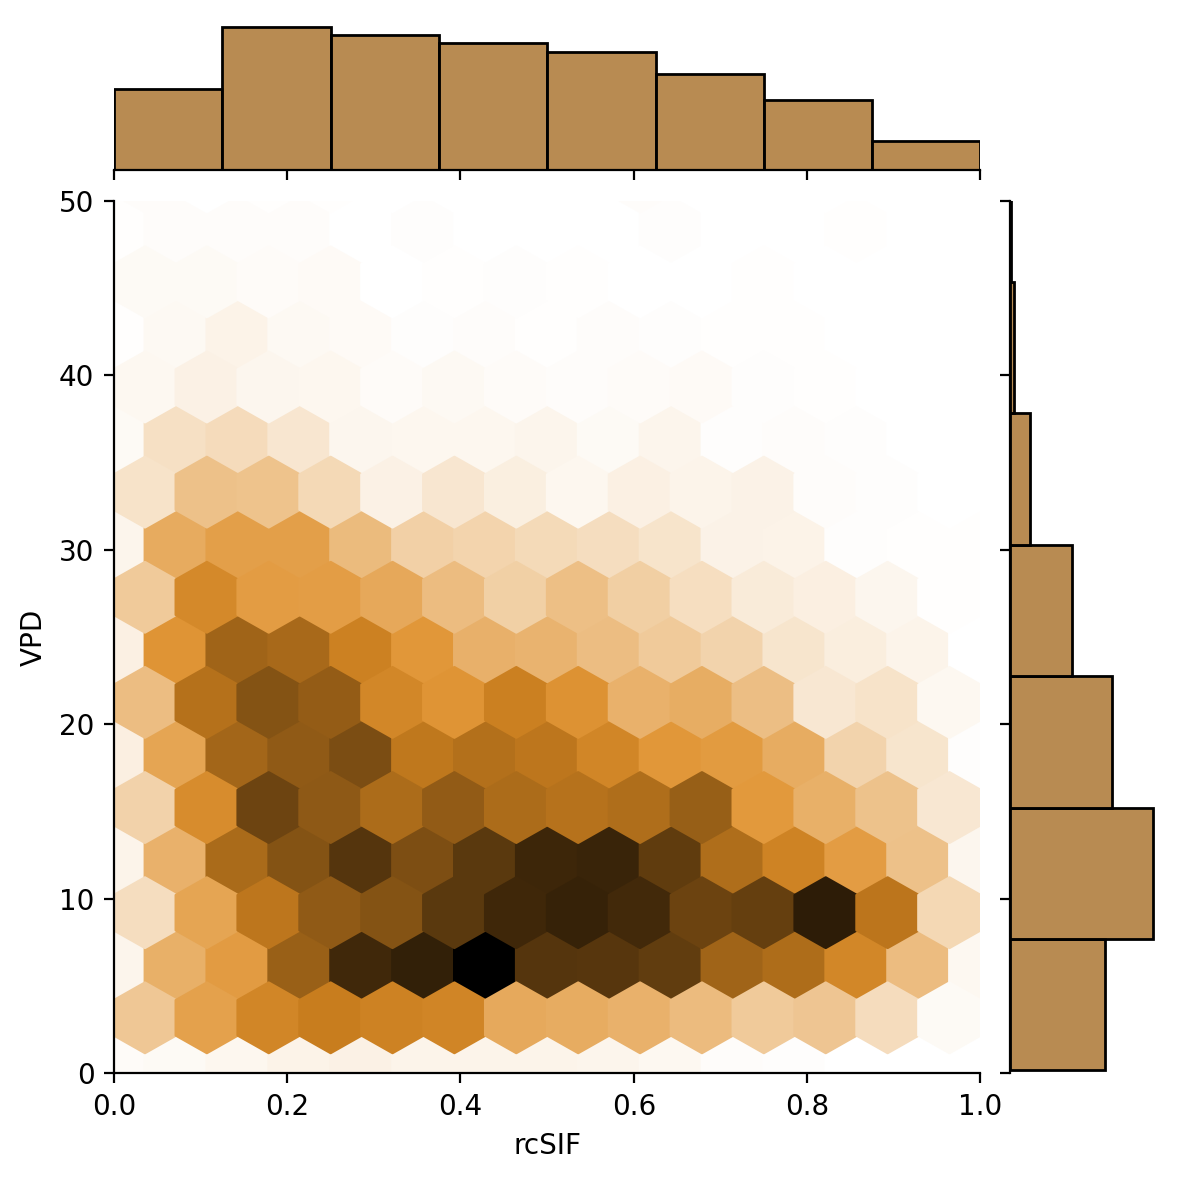

In [91]:
sns_grassland_rcsif_plot= sns.jointplot(data= grassland_fire_clim_df[grassland_fire_clim_df.rcSIF > 0], x="rcSIF", y="VPD", xlim= (0, 1), ylim= (0, 50), \
                                                                kind= 'hex', color= sns.color_palette(palette='BrBG')[0], gridsize= (14, 10), \
                                                                marginal_kws=dict(bins= 8, rug=True))
sns_grassland_rcsif_plot.savefig('../plots/grassland_vpd_rcsif_plot_fires.pdf')

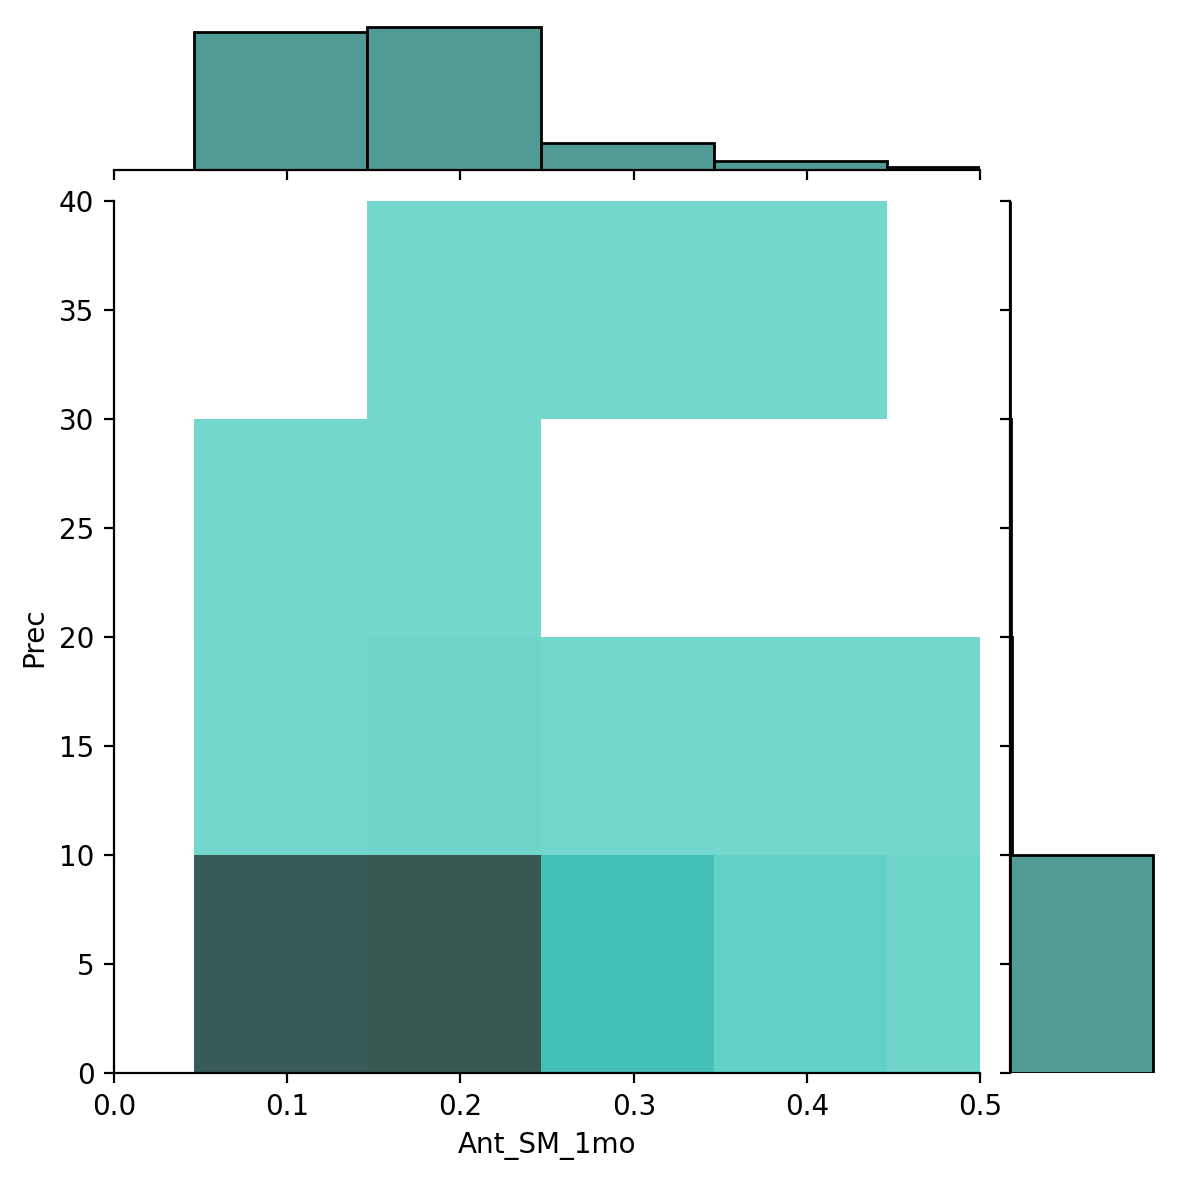

In [87]:
sns_forest_prec_sm_plot= sns.jointplot(data=forest_fire_clim_df[forest_fire_clim_df.SM > 0], x="Ant_SM_1mo", y="Prec", xlim= (0, 0.5), ylim= (0, 40), \
                                                                kind= 'hist', color= sns.color_palette(palette='BrBG')[5], binwidth=(0.1, 10), \
                                                                marginal_kws=dict(bins=5, rug=True)) 
sns_forest_prec_sm_plot.savefig('../plots/forest_prec_ant_sm_1mo_plot_fires.pdf')

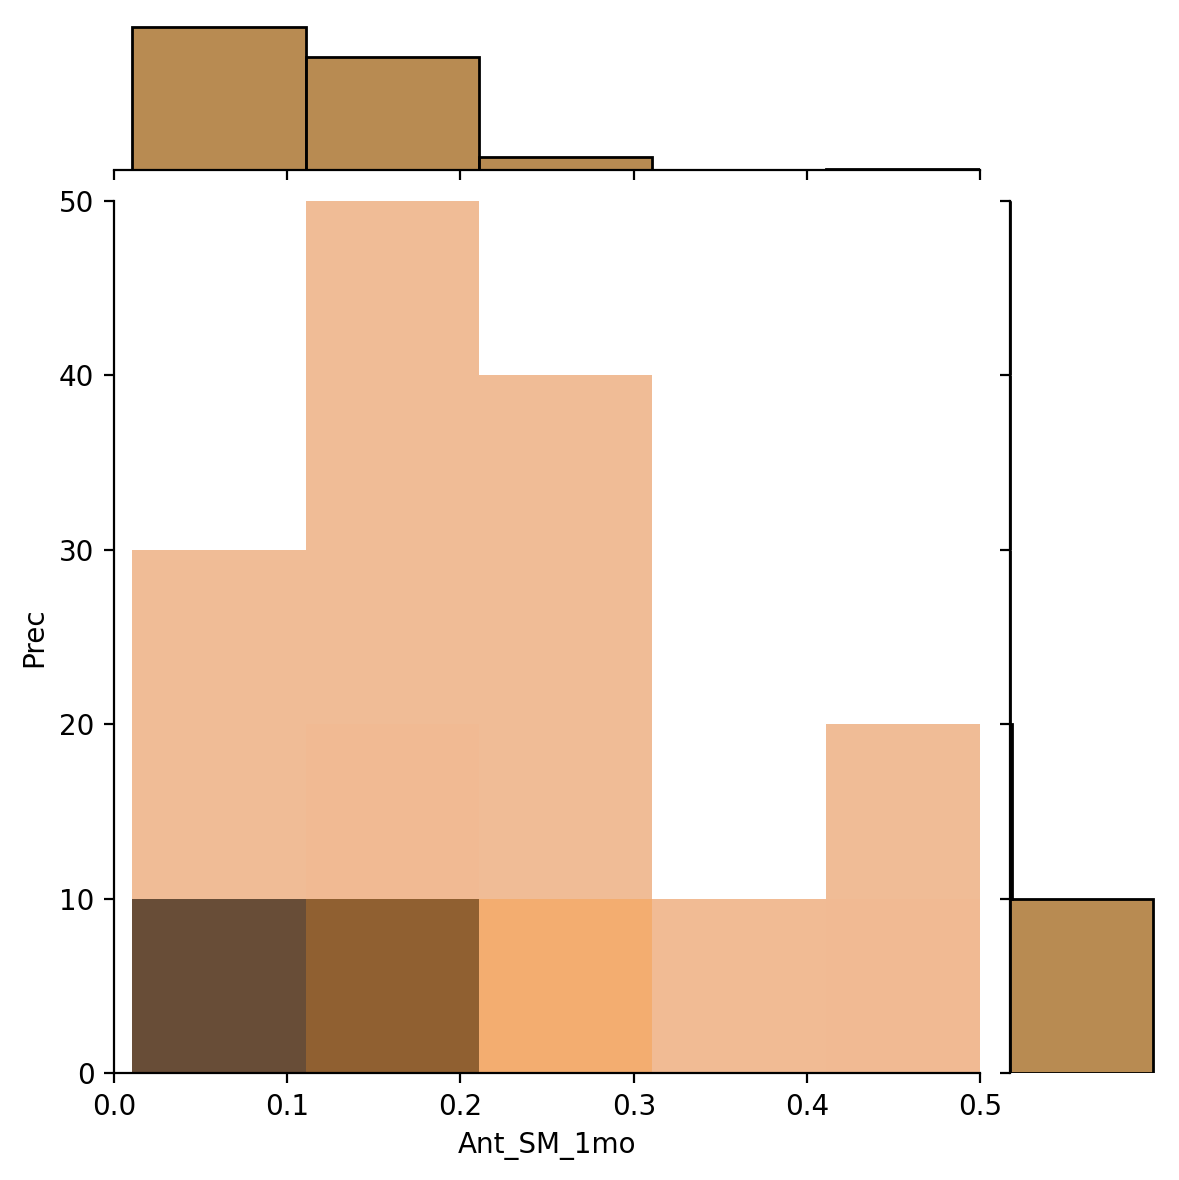

In [95]:
sns_grassland_prec_sm_plot= sns.jointplot(data= grassland_fire_clim_df[grassland_fire_clim_df.SM > 0], x="Ant_SM_1mo", y="Prec", xlim= (0, 0.5), ylim= (0, 50), \
                                                                kind= 'hist', color= sns.color_palette(palette='BrBG')[0], binwidth=(0.1, 10), \
                                                                marginal_kws=dict(bins= 5, rug=True)) #binwidth=(0.1, 10)
sns_grassland_prec_sm_plot.savefig('../plots/grassland_prec_ant_sm_1mo_plot_fires.pdf')

In [98]:
tot_fire_clim_df= pd.concat([forest_fire_clim_df, grassland_fire_clim_df, shrub_fire_clim_df]).reset_index(drop=True)

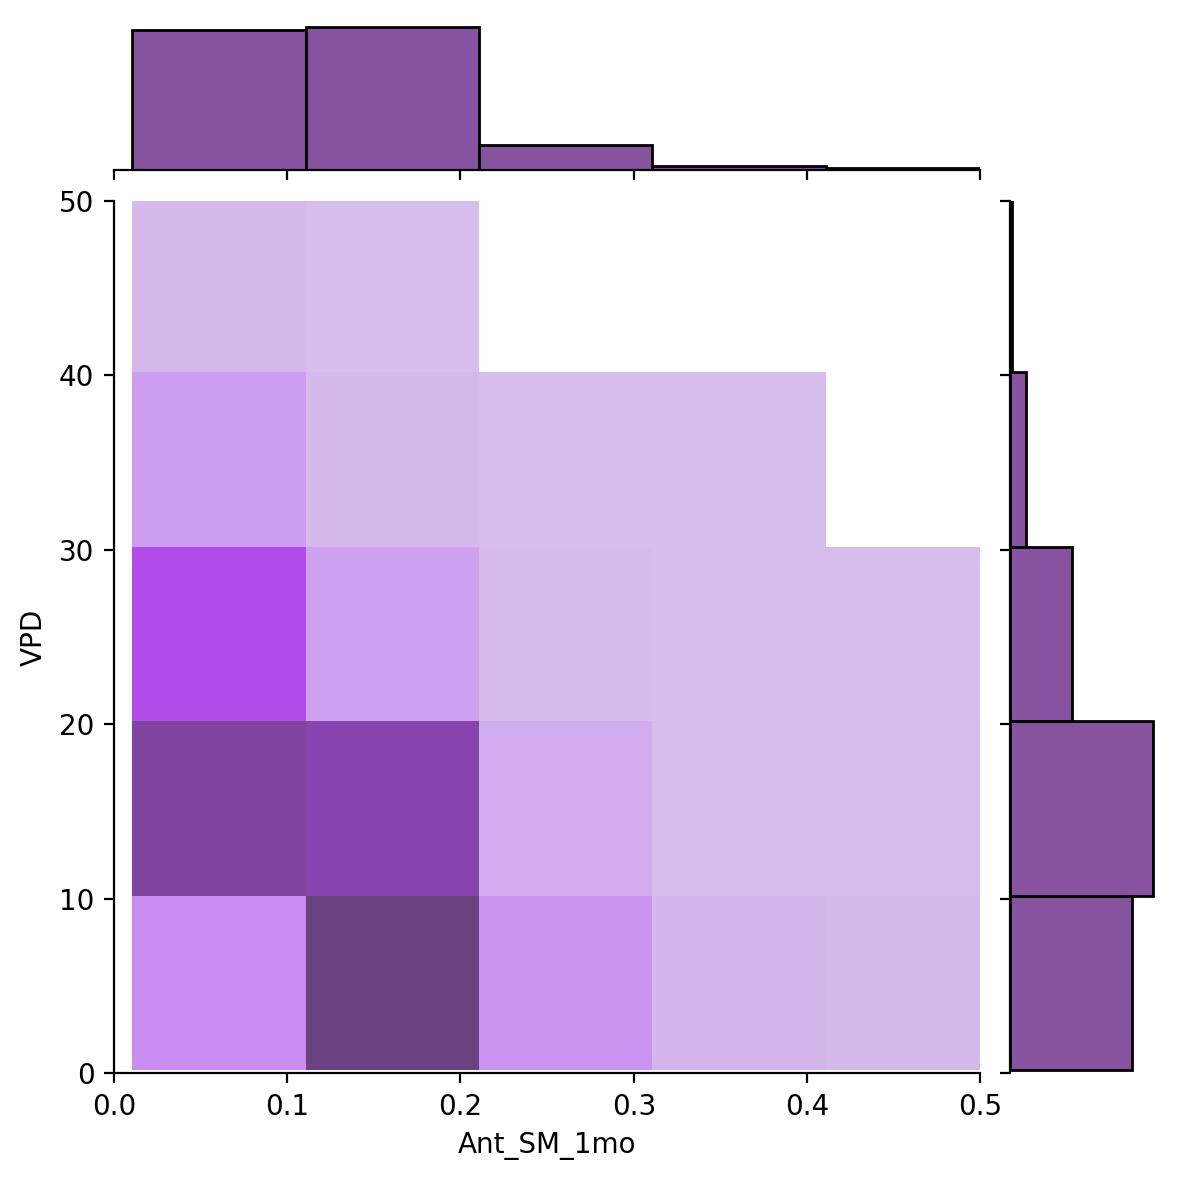

In [109]:
sns_tot_sm_plot= sns.jointplot(data= tot_fire_clim_df[tot_fire_clim_df.SM > 0], x="Ant_SM_1mo", y="VPD", xlim= (0, 0.5), ylim= (0, 50), \
                                                                kind= 'hist', color= sns.color_palette(palette='magma')[1], binwidth=(0.1, 10), \
                                                                marginal_kws=dict(bins= 8, rug=True)) 
sns_tot_sm_plot.savefig('../plots/tot_vpd_ant_sm_1mo_plot_fires.pdf')

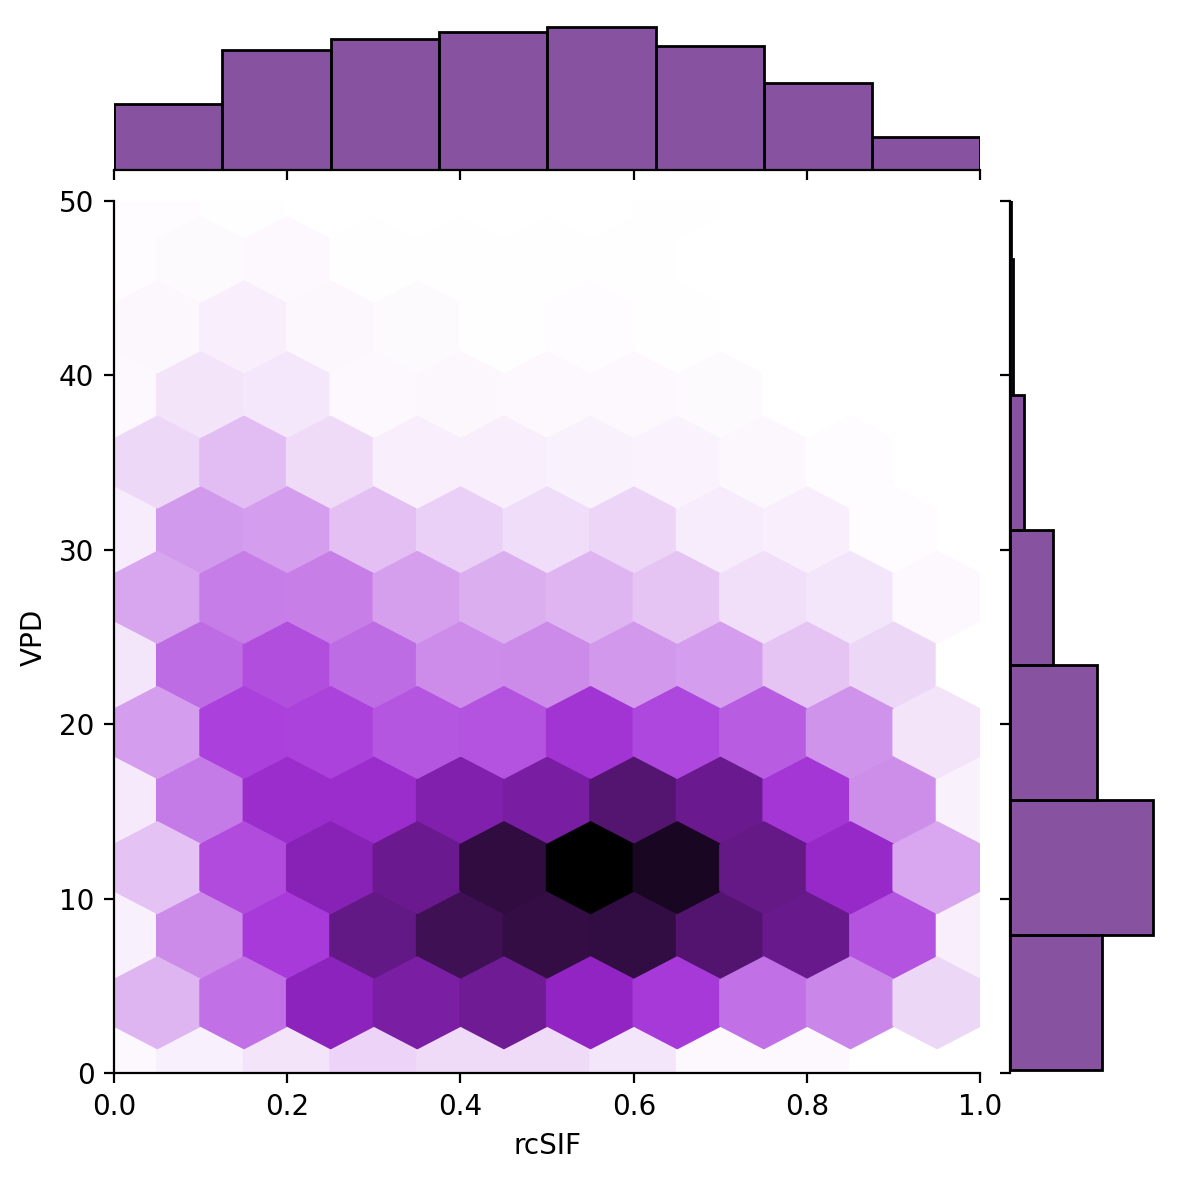

In [107]:
sns_tot_sm_plot= sns.jointplot(data= tot_fire_clim_df[tot_fire_clim_df.rcSIF > 0], x="rcSIF", y="VPD", xlim= (0, 1), ylim= (0, 50), \
                                                                kind= 'hex', color= sns.color_palette(palette='magma')[1], gridsize= (10, 8), \
                                                                marginal_kws=dict(bins= 8, rug=True)) 
sns_tot_sm_plot.savefig('../plots/tot_vpd_rcsif_plot_fires.pdf')